In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append('..')
from data_utils import *

In [4]:
# session = "PEDRI_Ketamine_20220106"
session = "SPOCK_Ketamine_20210712"
all_data_dir = "/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat/"
data_class = get_data_class(session, all_data_dir)

# all_data_dir = "/millerdata/data/common/datasets/anesthesiaLvrOdd/mat/"
# data_class = ''

In [4]:
variables = ['electrodeInfo', 'lfp', 'sessionInfo', 'trialInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class)

Loading data: ['electrodeInfo', 'lfp', 'sessionInfo', 'trialInfo', 'lfpSchema']...
electrodeInfo : dict with keys[Properties,area,array,channel,chnlID,electrode,file,gridLoc,hasLFP,hemisphere,numUnits,session,]

lfp : numpy.array(20044884,128,) of type float64

sessionInfo : dict with keys[Properties,date,dose,drug,expType,infusionEnd,infusionStart,numCorrect,numTrials,pctCorrect,session,subject,tasks,]

trialInfo : dict with keys[Properties,blockNum,condition,lvr_correct,lvr_outcome,lvr_reactionTime,lvr_responseDir,lvr_responseTime,lvr_rewardTime,lvr_toneOffset,lvr_toneOnset,odd_blockStd,odd_blockType,odd_globalOddball,odd_localOddball,odd_sequence,odd_sequenceEnd,odd_sequenceStart,odd_subblockType,odd_toneOffsets,odd_toneOnsets,odd_trialInBlock,refTime,session,task,trial,trialEnd,trialStart,]

lfpSchema : dict with keys[dataDim,dataUnits,description,dims,history,index,indexUnits,mask,smpInterval,smpRate,timeUnits,userData,]

Data loaded (took 184.76 seconds)


In [5]:
electrode_info, lfp, session_info, trial_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['sessionInfo'], session_vars['trialInfo']

In [6]:
session_info

{'Properties': {'Description': 'Per-session event data',
  'DimensionNames': array(['Session', 'Variable'], dtype=object),
  'RowNames': 'SPOCK_Ketamine_20210707',
  'UserData': {'history': array(['load from /mnt/common/Jesus/raw/SPOCK/Ketamine/SPOCK_Ketamine_20210707.nev',
          'convertUnits(ticks,s)'], dtype=object)},
  'VariableContinuity': array([], dtype=uint64),
  'VariableDescriptions': array(['SessionID string', 'Subject name', 'Experiment types', 'Date',
         'Tasks run in session', 'Total number of trials',
         'Number of correct trials (over all trials)',
         'Percent correct responses (over all trials)',
         'Drug (or saline or sham) used in session',
         'Drug dosage (mg/kg or ug/kg) used in session',
         'Start of anesthetic drug IM infusion(s)',
         'End of anesthetic drug IM infusion(s)'], dtype=object),
  'VariableNames': array(['session', 'subject', 'expType', 'date', 'tasks', 'numTrials',
         'numCorrect', 'pctCorrect', 'dr

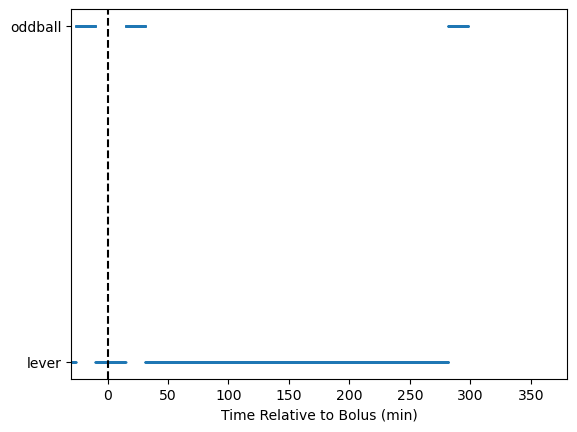

In [29]:
trial_indicator = np.zeros(len(trial_info['trialStart']))
trial_indicator[trial_info['task'] == 'oddball'] = 1

plt.scatter((trial_info['trialStart'] - session_info['infusionStart'])/60, trial_indicator, s=0.23)
plt.xlabel('Time Relative to Bolus (min)')
plt.yticks([0, 1], ['lever', 'oddball'])
plt.axvline(0, linestyle='--', c='k')
plt.xlim([-30, 380])
plt.show()

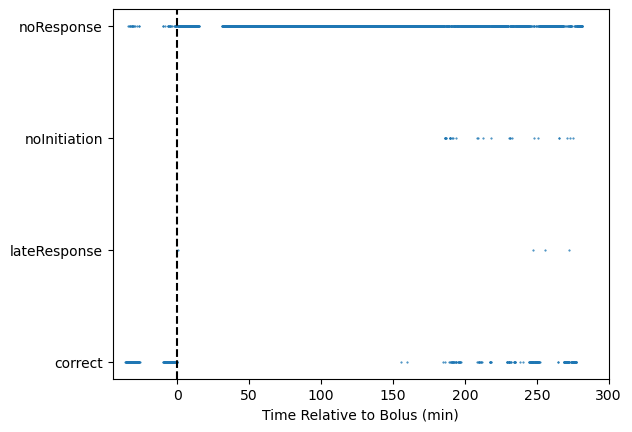

In [8]:
trial_indicator = np.zeros(len(trial_info['trialStart']), dtype=int)
trial_indicator[trial_info['task'] == 'oddball'] = 1
lvr_trials = [i for i, ind in enumerate(trial_indicator) if ind == 0]

outcomes = np.unique(trial_info['lvr_outcome'])
outcome_inds = np.array([np.where(outcome == outcomes)[0][0] for outcome in trial_info['lvr_outcome']])

# plt.scatter((trial_info['trialStart'] - session_info['infusionStarts'])/60, trial_indicator, s=0.23)
plt.scatter((trial_info['trialStart'][lvr_trials] - session_info['infusionStart'])/60, outcome_inds, s=0.23)
plt.xlabel('Time Relative to Bolus (min)')
plt.yticks(np.arange(len(outcomes)), outcomes)
plt.axvline(0, linestyle='--', c='k')
plt.xlim([-45, 300])
plt.show()

In [10]:
session_info['infusionStart']/60

36.21531166666667

In [30]:
oddball_windows = []
oddball_on = False
for ind in range(len(trial_info['task'])):

    t = trial_info['trialStart'][ind]
    task = trial_info['task'][ind]
    
    if task == 'oddball' and not oddball_on:
        oddball_on = True
        oddball_windows.append([(t - session_info['infusionStart'])/60, np.Inf])
    if task == 'lever' and oddball_on:
        oddball_on = False
        oddball_windows[-1][-1] = (t - session_info['infusionStart'])/60
    if ind == len(trial_info['task']) - 1:
        oddball_windows[-1][-1] = (t - session_info['infusionStart'])/60

In [31]:
oddball_windows

[[-26.136196111111115, -10.056611666666667],
 [15.069898888888892, 31.149055555555552],
 [281.7461122222223, 297.7912072222223]]

In [13]:
trial_info

{'Properties': {'Description': 'Per-trial event data',
  'DimensionNames': array(['Trial', 'Variable'], dtype=object),
  'RowNames': array([], dtype=uint64),
  'UserData': {'history': array(['load from /mnt/common/Jesus/raw/SPOCK/Ketamine/SPOCK_Ketamine_20210707.nev',
          'convertUnits(ticks,s)', 'unTrialParse'], dtype=object),
   'isTrialRefd': False},
  'VariableContinuity': array([], dtype=uint64),
  'VariableDescriptions': array(['Trial number', "Task run on given trial ('oddball'|'lever')",
         'Trial block number (0-14; 1-4, 6-9, 11-14  are oddball; 0,5,10 are lever task)',
         'Condition number (1-6; 1-4 are oddball, 5-6 are lever)',
         'Start of trial',
         'Trial reference event (toneOnset for lever, sequenceStart for oddball)',
         'Time from cue tone onset to lever press',
         'Direction of lever/joystick deflection', 'Trial outcome',
         'Correct trial (1) | any error (0)',
         'Onset of cue tone instructing lever press',
     

# Test Session Structure

In [5]:
# sessions = [f[:-4] for f in os.listdir(os.path.join(all_data_dir, 'leverOddball')) if f.endswith('.mat')]

In [10]:
session_info

{'Properties': {'Description': 'Per-session event data',
  'DimensionNames': array(['Session', 'Variable'], dtype=object),
  'RowNames': 'SPOCK_Ketamine_20210712',
  'UserData': {'history': array(['load from /mnt/common/Jesus/raw/SPOCK/Ketamine/SPOCK_Ketamine_20210712.nev',
          'convertUnits(ticks,s)'], dtype=object)},
  'VariableContinuity': array([], dtype=uint64),
  'VariableDescriptions': array(['SessionID string', 'Subject name', 'Experiment types', 'Date',
         'Tasks run in session', 'Total number of trials',
         'Number of correct trials (over all trials)',
         'Percent correct responses (over all trials)',
         'Drug (or saline or sham) used in session',
         'Drug dosage (mg/kg or ug/kg) used in session',
         'Start of anesthetic drug IM infusion(s)',
         'End of anesthetic drug IM infusion(s)'], dtype=object),
  'VariableNames': array(['session', 'subject', 'expType', 'date', 'tasks', 'numTrials',
         'numCorrect', 'pctCorrect', 'dr

In [14]:
variables = ['electrodeInfo', 'sessionInfo']

In [15]:
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, session_info = session_vars['electrodeInfo'], session_vars['sessionInfo']

In [18]:
T/1000

22703.472

In [19]:
window = 15
T_pred = 15
stride = 15

In [23]:
T

22703472

In [24]:
int(np.floor((T - ((window + T_pred)/dt))/(stride/dt)) + 1)

1512

In [11]:
session_info['infusionStart']

2165.571

In [44]:
session_infos = []
trial_infos = []
for session in tqdm(sessions):
    variables = ['electrodeInfo', 'sessionInfo', 'trialInfo']
    session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    electrode_info, session_info, trial_info = session_vars['electrodeInfo'], session_vars['sessionInfo'], session_vars['trialInfo']
    session_infos.append(session_info)
    trial_infos.append(trial_info)

  0%|          | 0/19 [00:00<?, ?it/s]

In [45]:
for session_info in session_infos:
    print(session_info['infusionStart']/60)
    print(session_info['dose'])

nan
1.0
36.09750944444445
1.0
36.10521555555556
1.0
36.11516055555556
1.0
36.21531166666667
10.0
36.10795388888889
1.0
36.23385444444445
1.0
36.09894555555556
10.0
36.07974111111112
10.0
36.08934555555556
10.0
36.10088888888889
1.0
36.10292555555556
10.0
36.083891111111114
1.0
36.09636555555556
10.0
36.09303944444445
10.0
36.09607333333334
10.0
36.09656555555556
10.0
36.09285
10.0
[36.09675944 36.10447778]
10.0


In [46]:
sessions

['PEDRI_Ketamine_20220203',
 'PEDRI_Ketamine_20220224',
 'PEDRI_Ketamine_20220228',
 'PEDRI_Ketamine_20220126',
 'SPOCK_Ketamine_20210707',
 'PEDRI_Ketamine_20220211',
 'PEDRI_Ketamine_20220425',
 'PEDRI_Ketamine_20220209',
 'PEDRI_Ketamine_20220217',
 'SPOCK_Ketamine_20210715',
 'PEDRI_Ketamine_20220215',
 'PEDRI_Ketamine_20220201',
 'PEDRI_Ketamine_20220128',
 'PEDRI_Ketamine_20220111',
 'PEDRI_Ketamine_20220222',
 'PEDRI_Ketamine_20220124',
 'PEDRI_Ketamine_20220106',
 'SPOCK_Ketamine_20210712',
 'PEDRI_Ketamine_20220113']